In [ ]:
# https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c
# https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
# https://github.com/cjhutto/vaderSentiment
# http://docs.tweepy.org/en/latest/streaming_how_to.html
# https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf

In [1]:
#Imports
import tweepy
import pandas as pd
import numpy as np
import os
import time
import sys
import requests
import json
import random
from datetime import datetime, timezone
from listenerOverride import *
from tweepy import Stream
from dateutil.parser import *
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
import re

#Load twitter credentials
from credentials import *
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
myListener = StdOutListener()
stream = Stream(auth, myListener)

In [2]:
def findWordinStream(stream, myListener, word, stopWords, counter=0):
    rtnBool = False
    stream.filter(track=[word], languages=['en'])
    if word.lower() in myListener.foundStatus.lower() and not any(x.lower() in myListener.foundStatus.lower().strip().split() for x in stopWords):
        rtnBool = True
    elif counter < 50:
        print(myListener.foundStatus.lower().strip().split())
        time.sleep(5)
        rtnBool = findWordinStream(stream, myListener, word, stopWords, counter + 1)
    else:
        print("Exceeded maximum tries for some reason for word " + word)
        rtnBool = False
    return rtnBool

In [3]:
tag = "Trump"

In [4]:
#Ignore tweets with these words in the text
stopWords = ['RT @']
matrix = []

#Load up current tweets so we don't write them twice if they are still in scope
tweetsDB = "tweets.json"
r = requests.get(FB_URL + tweetsDB)
r = r.json()
keys = []
ids = []
if r:
    data = [r[i] for i in r]
    df = pd.DataFrame.from_dict(data, orient='columns')
    ids = np.unique(df.TweetID)
    tags = np.unique([x.lower() for x in df['Tag']])
    keys = [(row.TweetID, row.Tag) for index, row in df.iterrows()] #clustered primary key

In [79]:
#('1135004364584697856', 'Trump') in [(row.TweetID, row.Tag) for index, row in df.iterrows()]

In [6]:
pages = tweepy.Cursor(api.search, q=tag, tweet_mode='extended', include_entities=True, lang='en').pages(50)
for page in pages:
    for tweetData in page:
        tweet = tweetData.__dict__
        if not tweet["retweeted"] and not any(substring in tweet["_json"]["full_text"] for substring in stopWords):
    #endtime=time.time()+500.0 #1minute
    #while (time.time()<endtime):
    #    if findWordinStream(stream, myListener, tag, stopWords):
            #tweet = myListener.foundTweetData
            if not (tweet["id_str"], tag) in keys:
                #included URLS
                url = ""
                hashtags = ""
                if tweet["entities"]["urls"]:
                    if tweet["entities"]["urls"][0]["expanded_url"]:
                        url = tweet["entities"]["urls"][0]["expanded_url"]
                if tweet['entities']['hashtags']:
                    hashtags = "|".join([hashtag_item['text'] for hashtag_item in tweet['entities']['hashtags']]) #concat on pipe
                #Add columns that we want to track            
                tweetLink = "https://twitter.com/" + tweet["user"].__dict__["screen_name"] + "/status/" + tweet["id_str"]
                matrix.append([tweet["id_str"],
                tweet["created_at"],
                tweet["user"].__dict__["screen_name"],
                tweet["user"].__dict__["name"],
                tweet["user"].__dict__["verified"],
                tweet["user"].__dict__["location"],
                tweet["_json"]["full_text"],            
                url,
                tweet["favorite_count"],
                tweet["retweet_count"],
                tweetLink,
                hashtags])
                ids = np.append(ids, tweet["id_str"])
            #sleep(5)

In [7]:
#Create dataframe
if matrix:
    columnNames = ["TweetID", "CreatedAt", "User_ScreenName", "User_Name", "User_IsVerified",
                   "User_Loc", "Tweet_Text", "Tweet_Urls", "Tweet_FavCount", "Tweet_RTCount", "Tweet_Link", "Hashtags"]
    df = pd.DataFrame(matrix)
    df.columns = columnNames

In [8]:
len(df)

137

In [9]:
# import pprint
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(api.rate_limit_status())

In [10]:
#Tokenize Sentences properly
def format_sentence(sent):
    return({word: True for word in nltk.word_tokenize(sent)})

#print(format_sentence("This cat isn't very cute"))

#Simple Function to Clean Tweets
def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters,
    and usernames using simple regex statements.
    '''
    tweet = tweet.lower().strip()
    return ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z'\-])|(\w+:\/\/\S+)", " ", tweet).split())

#Leave caps and emojiis for VADER
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweet2(tweet):
    # Happy Emoticons
    emoticons_happy = set([
        ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
        ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
        '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
        'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
        '<3'
        ])
    # Sad Emoticons
    emoticons_sad = set([
        ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
        ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
        ':c', ':{', '>:\\', ';('
        ])
    #combine sad and happy emoticons
    emoticons = emoticons_happy.union(emoticons_sad)
    #Emoji patterns
    emoji_pattern = re.compile("["
             u"\U0001F600-\U0001F64F"  # emoticons
             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
             u"\U0001F680-\U0001F6FF"  # transport & map symbols
             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
             u"\U00002702-\U000027B0"
             u"\U000024C2-\U0001F251"
             "]+", flags=re.UNICODE)
    
    # remove twitter Return handles (RT @xxx:)
    tweet = remove_pattern(tweet, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    tweet = remove_pattern(tweet, "@[\w]*")
    # remove URL links (httpxxx)
    tweet = remove_pattern(tweet, "https?://[A-Za-z0-9./]*")
    return tweet
    #don't remove emojiis, or send to lower for VADER processing

In [11]:
#Imports
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [12]:
#df["Clean_Date"] = [datetime.datetime.strftime(created, '%D') for created in df.CreatedAt]
df["Tag"] = tag
#df["CreatedAtLocal"] = [parse(created).replace(tzinfo=timezone.utc).astimezone(tz=None) for created in df.CreatedAt]
df["CreatedAtLocal"] = df.CreatedAt.dt.tz_localize('utc').dt.tz_convert('US/Central')
df["Clean_Date"] = [datetime.strftime(created, '%D %I:%M%p') for created in df.CreatedAtLocal]
df['CreatedAt'] = df['CreatedAt'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['CreatedAtLocal'] = df['CreatedAtLocal'].dt.strftime('%Y-%m-%d %H:%M:%S')
df["Clean_Text"] = [clean_tweet(i) for i in df.Tweet_Text]
df["Less_Clean_Text"] = [clean_tweet2(i) for i in df.Tweet_Text]
df["Sentiment"] = [TextBlob(cleanedTweet).sentiment.polarity for cleanedTweet in df.Clean_Text]
df["Sentiment_VADER"] = [analyser.polarity_scores(cleanedTweet)["compound"] for cleanedTweet in df.Less_Clean_Text]
df["Sentiment_Comb"] = (df.Sentiment + df.Sentiment_VADER) / 2

In [13]:
df.sort_values(by='CreatedAtLocal', inplace=True)
df.reset_index(inplace=True, drop=True)

In [14]:
print(np.mean(df.Sentiment))
print(np.mean(df.Sentiment_VADER))
print(np.mean(df.Sentiment_Comb))

0.06167389483995324
0.019400729927007296
0.0713742598034569


In [15]:
df.head()

,TweetID,CreatedAt,User_ScreenName,User_Name,User_IsVerified,User_Loc,Tweet_Text,Tweet_Urls,Tweet_FavCount,Tweet_RTCount,Tweet_Link,Hashtags,Tag,CreatedAtLocal,Clean_Date,Clean_Text,Less_Clean_Text,Sentiment,Sentiment_VADER,Sentiment_Comb
0,1135360694839390208,2019-06-03 01:40:58,WhittyPics,Dennis ,False,"Clover, SC",Trump’s Two-Front Trade War Is Unsustainable h...,http://nymag.com/intelligencer/2019/06/trumps-...,0,0,https://twitter.com/WhittyPics/status/11353606...,,Trump,2019-06-02 20:40:58-05:00,06/02/19 08:40PM,trump s two-front trade war is unsustainable,Trump’s Two-Front Trade War Is Unsustainable,0.000000,-0.5994,-0.299700
1,1135360698148687872,2019-06-03 01:40:59,Acended,Daniel Jackson,False,,@justinamash @jaketapper @CR your job is to su...,,0,0,https://twitter.com/Acended/status/11353606981...,,Trump,2019-06-02 20:40:59-05:00,06/02/19 08:40PM,your job is to submit to the will of the peopl...,your job is to submit to the will of the pe...,0.000000,0.0000,0.000000
2,1135360699633459201,2019-06-03 01:40:59,DevinsCat1,DevinsCat,False,United States,@NOW1SOLAR @realDonaldTrump I read that! Fasc...,,1,1,https://twitter.com/DevinsCat1/status/11353606...,,Trump,2019-06-02 20:40:59-05:00,06/02/19 08:40PM,i read that fascinating new scam to me there a...,I read that! Fascinating! New scam to me. ...,0.209091,-0.5550,-0.068409
3,1135360702909210624,2019-06-03 01:41:00,Cynthia9175583,Women on a Mission🌊🌊💙🇺🇸🌍,False,,"The presidency has gone to his head!\n""Trump a...",https://twitter.com/i/events/1135351988638572546,0,0,https://twitter.com/Cynthia9175583/status/1135...,,Trump,2019-06-02 20:41:00-05:00,06/02/19 08:41PM,the presidency has gone to his head trump admi...,"The presidency has gone to his head!\n""Trump a...",0.000000,0.0000,0.000000
4,1135360703794163712,2019-06-03 01:41:00,GregRogersBulls,BullsFanBD,False,,@TheStrickdogJr @TaylorRooks Haha who did Trum...,,0,0,https://twitter.com/GregRogersBulls/status/113...,,Trump,2019-06-02 20:41:00-05:00,06/02/19 08:41PM,haha who did trump pay your boy mueller invest...,Haha who did Trump pay? Your boy Mueller inv...,0.200000,0.3818,0.390900


In [ ]:
# def checkTweetNotInDB(tweet, dataBase):
#     rtnBool = True
#     try:
#         r = requests.get(FB_URL + dataBase)
#         r = r.json()
#         for i in r:
#             if tweet.TweetID == r[i]["TweetID"]:
#                 rtnBool = False
#                 break
#    # Exceptions
#     except KeyboardInterrupt:
#         sys.exit("KeyboardInterrupt")
#     except Exception as e:
#         print(e)
#         pass
#     return rtnBool

In [18]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

# Fetch the service account key JSON file contents
cred = credentials.Certificate('SentimentAnalysisApp/sentiment-twitter-app-firebase-adminsdk.json')
# Initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {
    'databaseURL': FB_URL
})

ref = db.reference('tweets')
[ref.push(tweet.to_dict()) for index, tweet in df.iterrows()]

In [22]:

ref = db.reference('tweets')
[ref.push(tweet.to_dict()) for index, tweet in df.iterrows()]

In [24]:
ref.delete()

In [87]:
for x in range(0, len(df)):
    tweet = df.iloc[x]
    db_tweet = tweet.to_json()
    requests.post(FB_URL + tweetsDB, db_tweet) #slow, fix this

In [88]:
#Get data from database
r = requests.get(FB_URL + tweetsDB)
r = r.json()
data = [r[i] for i in r]
df = pd.DataFrame.from_dict(data, orient='columns')

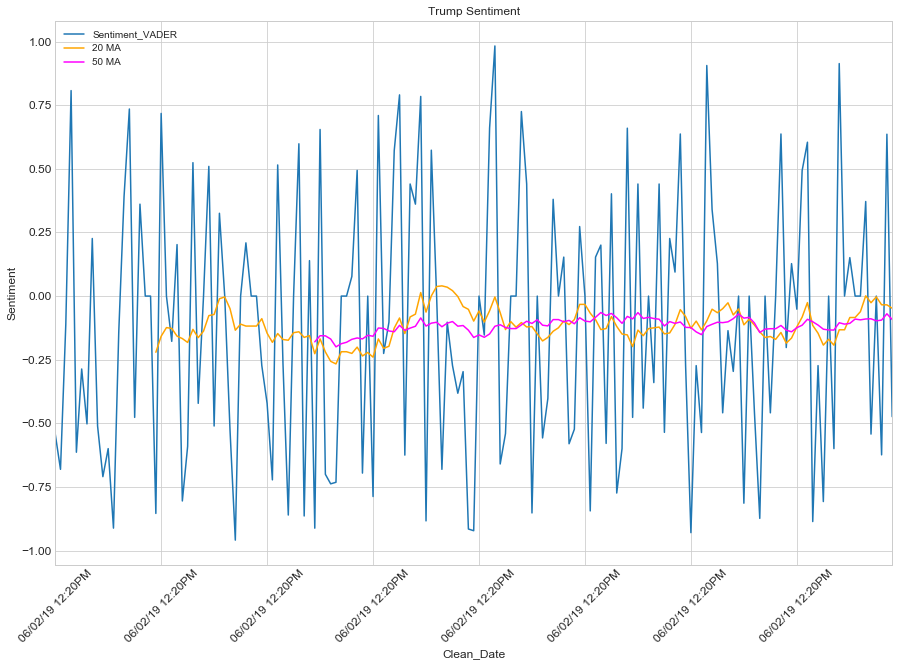

In [89]:
#Plot
vader = True
if vader:
    df["rolling_mean"] = df.Sentiment_VADER.rolling(window=20).mean()#.fillna(0)
    df["rolling_mean2"] = df.Sentiment_VADER.rolling(window=50).mean()#.fillna(0)

    ax = df.plot(x = 'Clean_Date', y = 'Sentiment_VADER', kind='line', title ="Trump Sentiment", figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Tweet Created", fontsize=12)
    ax.set_ylabel("Sentiment", fontsize=12)

    ax = df.plot(ax=ax, x = 'Clean_Date', y = "rolling_mean", label='20 MA', color='orange')
    ax = df.plot(ax=ax, x = 'Clean_Date', y = "rolling_mean2", label='50 MA', color='magenta')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.show()
else:
    df["rolling_mean"] = df.Sentiment.rolling(window=20).mean()#.fillna(0)
    df["rolling_mean2"] = df.Sentiment.rolling(window=50).mean()#.fillna(0)

    ax = df.plot(x = 'Clean_Date', y = 'Sentiment', kind='line', title ="Trump Sentiment", figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Tweet Created", fontsize=12)
    ax.set_ylabel("Sentiment", fontsize=12)

    ax = df.plot(ax=ax, x = 'Clean_Date', y = "rolling_mean", label='20 MA', color='orange')
    ax = df.plot(ax=ax, x = 'Clean_Date', y = "rolling_mean2", label='50 MA', color='magenta')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.show()  

In [91]:
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline

In [121]:
dataToPlot = df
#teamHeaders = dataToPlot.Teams.values
dataToPlot = dataToPlot[["Clean_Date", "Less_Clean_Text", "Tweet_Link", "Sentiment_VADER", "rolling_mean", "rolling_mean2"]]

fileNamePrefix = '\\HTML\\'
os.makedirs(os.getcwd() + fileNamePrefix, exist_ok=True)

plotTitle = tag + " Sentiment Tweets"
yLabel = 'Sentiment'
fileName = os.getcwd() + fileNamePrefix + tag + "_20190602_tweets"
yStart = -1.05
yEnd = 1.05
hoverFormat = '.2f'

In [146]:
x = dataToPlot.index.values
data = []
trace = go.Scatter(
        x=x,
        y=dataToPlot["Sentiment_VADER"],
        text = [row.Less_Clean_Text[0:100] + "..." for index, row in dataToPlot.iterrows()],
        mode='lines+markers',
        name = "Sentiment_VADER",
        line = dict(
                color = 'rgb(6, 174, 213)',
                width = 4,
                shape='linear'))

data.append(trace)
plotAnnotes = []
for index, row in dataToPlot.iterrows():
    plotAnnotes.append(dict(x=index,
                            y=row.Sentiment_VADER,
                            text="<a href='" + row.Tweet_Link + "'> </a>".format("Text"),
                            showarrow=False,
                            xanchor='center',
                            yanchor='middle',
                            ))
trace = go.Scatter(
        x=x,
        y=dataToPlot["rolling_mean"],
        mode='lines+markers',
        name = "20 MA",
        line = dict(
                color = 'rgb(255,165,0)',
                width = 4,
                shape='linear'))

data.append(trace)
trace = go.Scatter(
        x=x,
        y=dataToPlot["rolling_mean2"],
        mode='lines+markers',
        name = "50 MA",
        line = dict(
                color = 'rgb(255,0,255)',
                width = 4,
                shape='linear'))

data.append(trace)
layout = go.Layout(
    title = plotTitle,
    annotations=plotAnnotes,
    yaxis = dict(title = yLabel,
                 range = [yStart, yEnd],
                 hoverformat = hoverFormat),
    xaxis = go.layout.XAxis(
        tickmode = 'array',
        tickvals = dataToPlot.index.values[0::10],
        ticktext = dataToPlot.Clean_Date[0::10]
    )
)

fig = go.Figure(data = data, layout = layout)
offline.plot(fig, filename = fileName + '.html')

'file://C:\\Users\\abooth\\Documents\\Python Scripts\\HTML\\Trump_20190602_tweets.html'

In [156]:
df[df.Tag.str.lower() == "Trump".lower()]

,Clean_Date,Clean_Text,CreatedAt,CreatedAtLocal,Hashtags,Less_Clean_Text,Sentiment,Sentiment_Comb,Sentiment_VADER,Tag,...,Tweet_Link,Tweet_RTCount,Tweet_Text,Tweet_Urls,User_IsVerified,User_Loc,User_Name,User_ScreenName,rolling_mean,rolling_mean2
0,06/02/19 12:20PM,they are so blind btw i see you left out the q...,1559496004000,1559496004000,,They are so blind. Btw I see you left out the...,-0.250000,-0.520500,-0.5410,Trump,...,https://twitter.com/DavidSGilbert1/status/1135...,0,@usminority They are so blind. Btw I see you l...,,False,"Texas, USA",David S Gilbert,DavidSGilbert1,NaN,NaN
1,06/02/19 12:20PM,ex-evangelist rains holy hell on franklin grah...,1559496004000,1559496004000,,Ex-evangelist rains holy Hell on Franklin Grah...,0.000000,-0.340400,-0.6808,Trump,...,https://twitter.com/shawrls/status/11352346415...,0,Ex-evangelist rains holy Hell on Franklin Grah...,https://www.rawstory.com/2019/06/ex-evangelist...,False,"Texas, USA",Bob Shaw,shawrls,NaN,NaN
2,06/02/19 12:20PM,tds leads to pretending something happened tha...,1559496004000,1559496004000,,TDS leads to pretending something happened th...,-0.025000,-0.080750,-0.1115,Trump,...,https://twitter.com/Orwell_2012/status/1135234...,0,@waltshaub TDS leads to pretending something h...,,False,"Washington, DC",Georgette O,Orwell_2012,NaN,NaN
3,06/02/19 12:20PM,jerry west will receive the presidential medal...,1559496004000,1559496004000,,Jerry West will receive the Presidential Medal...,0.000000,0.403700,0.8074,Trump,...,https://twitter.com/SInow/status/1135234641445...,0,Jerry West will receive the Presidential Medal...,http://go.si.com/M2MLphe,True,"New York, NY",Sports Illustrated,SInow,NaN,NaN
4,06/02/19 12:20PM,americans are paying trump's tax increases on ...,1559496005000,1559496005000,,Americans are paying Trump's tax increases on ...,0.000000,-0.306800,-0.6136,Trump,...,https://twitter.com/Katulis/status/11352346455...,0,Americans are paying Trump's tax increases on ...,https://www.washingtonpost.com/opinions/no-chi...,False,Global,Brian Katulis,Katulis,NaN,NaN
5,06/02/19 12:20PM,trump or white house tweeting about mueller is...,1559496005000,1559496005000,,Trump or White House tweeting about Mueller i...,-0.275000,-0.418250,-0.2865,Trump,...,https://twitter.com/DAVIDFERNANDES8/status/113...,0,@ABCPolitics Trump or White House tweeting abo...,,False,"Denver, Colorado",Cake & Capitalism - Equality 7-2521,DAVIDFERNANDES8,NaN,NaN
6,06/02/19 12:20PM,remember this gem mark when you demanded presi...,1559496005000,1559496005000,,"Remember this gem, Mark? When you demanded Pr...",0.000000,-0.251150,-0.5023,Trump,...,https://twitter.com/BattyBlogger/status/113523...,0,"@MarkBoslough Remember this gem, Mark? When yo...",,False,"Antioch, California",Brent Allen Thale,BattyBlogger,NaN,NaN
7,06/02/19 12:20PM,yes you did it s not made up by the fake news ...,1559496005000,1559496005000,,"Yes, you did. It’s not made up by the “Fake...",-0.700000,-0.586850,0.2263,Trump,...,https://twitter.com/SchelleShocked/status/1135...,0,"@realDonaldTrump @CNN @nytimes Yes, you did. I...",https://www.thesun.co.uk/news/9196110/donald-t...,False,,Michelle,SchelleShocked,NaN,NaN
8,06/02/19 12:20PM,only televised hearings exposing the vast amou...,1559496005000,1559496005000,,Only televised hearings exposing the vast ...,0.000000,-0.255300,-0.5106,Trump,...,https://twitter.com/BillShedd/status/113523464...,0,@AnneMarieFlynn2 @EmmaPeele3 @BarbaraNavarro @...,,False,"Texas, USA",Bill Shedd,BillShedd,NaN,NaN
9,06/02/19 12:20PM,you've been on twitter for 2 years and have on...,1559496005000,1559496005000,,You've been on Twitter for 2 years and have ...,-0.231250,-0.586050,-0.7096,Trump,...,https://twitter.com/rustystubbs/status/1135234...,0,@laurabrodb @hayleymiller01 You've been on Twi...,,False,"Minnesota, USA","Cold Hands, Cold Feet.",rustystubbs,NaN,NaN


In [158]:
offline.plot(fig, include_plotlyjs=False, output_type='div')

'<div id="8c52f4ad-c872-409e-a172-fc66396d1c19" style="height: 100%; width: 100%;" class="plotly-graph-div"></div><script type="text/javascript">window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";\n        Plotly.plot(\n            \'8c52f4ad-c872-409e-a172-fc66396d1c19\',\n            [{"line": {"color": "rgb(6, 174, 213)", "shape": "linear", "width": 4}, "mode": "lines+markers", "name": "Sentiment_VADER", "text": [" They are so blind. Btw I see you left out the Q. What does that letter me. President Trump is being...", "Ex-evangelist rains holy Hell on Franklin Graham for getting in bed with the president - ...", " TDS leads to pretending something happened that simply did NOT happen. \\n\\nDOJ totally exonerated Tru...", "Jerry West will receive the Presidential Medal of Freedom, President Trump says  ...", "Americans are paying Trump\'s tax increases on trade - not China.\\n\\nJust like the Trump lie about Mexi...", " Trump or White House tweeting a